## ElasticNet Model Implementation for King County House Sales dataset

This code implements a custom ElasticNet regression model using Python. It combines both L1 (Lasso) and L2 (Ridge) regularization techniques, providing a flexible approach to linear regression that can handle datasets with multicollinearity and high dimensionality.

##### Load a dataset using openML from SKlearn datasets ( King County House Sales dataset: data_id=42165)
- The below line in the code loads the data
- X, y = load_openml_data(dataset_id=42165)

### Key Features of the ElasticNet Model

1. **Data Preprocessing**:
   - Removes rows with NaN values.
   - Identifies and removes outliers using the Interquartile Range (IQR) method.
   - Normalizes the features and the target variable to improve convergence during training.

2. **Model Training**:
   - The model is fit using gradient descent, iteratively updating coefficients to minimize the Mean Squared Error (MSE).
   - Convergence is checked based on the change in coefficients, allowing for early stopping when improvements become negligible.

3. **Prediction**:
   - The model provides predictions based on normalized input data, scaling the new data using the mean and standard deviation calculated during training.

4. **Evaluation**:
   - Model performance is evaluated using metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared (R²).
   - Predictions are cleaned of NaN values to ensure accurate evaluation.

5. **Visualization**:
   - Results can be visualized using scatter plots comparing true versus predicted values and a plot showing the loss (MSE) over the iterations.



Removing rows with NaN values: 339 rows removed.
Shapes after NaN removal - X: (1121, 37), y: (1121,)
Shapes after outlier removal - X: (1071, 37), y: (1071,)
Removing NaN values from evaluation: 339 rows removed.
Mean Absolute Error (MAE): 23163.5932
Mean Squared Error (MSE): 1705696757.1841
Root Mean Squared Error (RMSE): 41300.0818
R-squared (R²): 0.7522

Sample Predictions:
True Value: 208500.000, Predicted Value: 214327.599
True Value: 181500.000, Predicted Value: 188750.706
True Value: 223500.000, Predicted Value: 222498.641
True Value: 140000.000, Predicted Value: 187357.946
True Value: 250000.000, Predicted Value: 277962.108
Lengths - True Values: 1460, Predicted Values: 1121


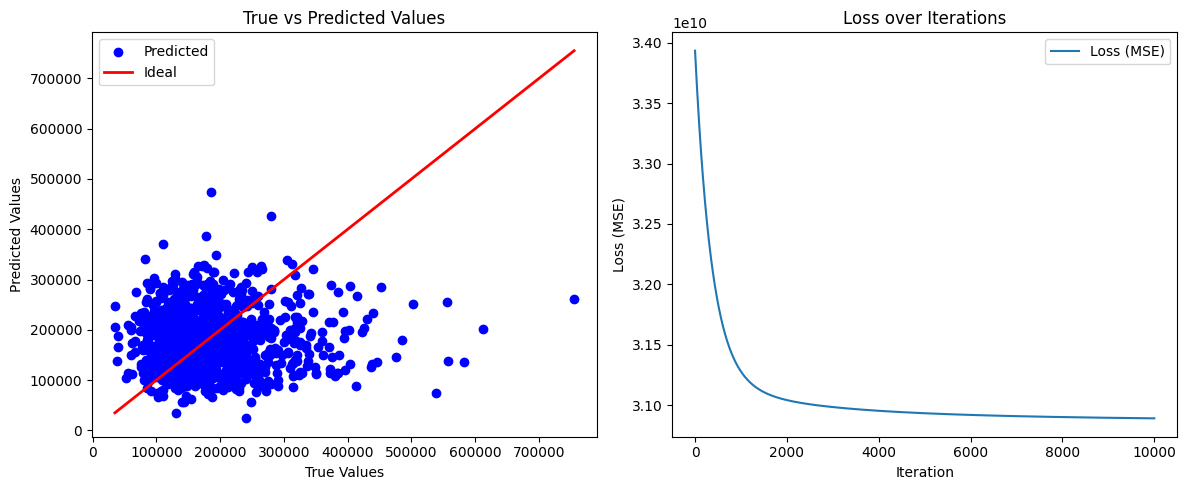

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.datasets import fetch_openml

class ElasticNetModel:
    def __init__(self, alpha=1.0, l1_ratio=0.5, max_iter=10000, tol=1e-4):
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        self.max_iter = max_iter
        self.tol = tol
        self.coef_ = None
        self.intercept_ = None
        self.loss_history = []  

    def fit(self, X, y):
        # Start by removing any rows with NaN values
        X, y = self.remove_nan_values(X, y)
        print(f"Shapes after NaN removal - X: {X.shape}, y: {y.shape}")

        # remove outliers
        X, y = self.remove_outliers(X, y)
        print(f"Shapes after outlier removal - X: {X.shape}, y: {y.shape}")

        # Normalize the features
        X_mean = np.mean(X, axis=0)
        X_std = np.std(X, axis=0)
        X_norm = (X - X_mean) / X_std

        # Normalize the target variable
        y_mean = np.mean(y)
        y_norm = y - y_mean

        n_samples, n_features = X_norm.shape
        self.coef_ = np.zeros(n_features)
        self.intercept_ = y_mean

        # Iteratively update coefficients
        for iteration in range(self.max_iter):
            y_pred = X_norm.dot(self.coef_) + self.intercept_
            
            # Check for NaN predictions
            if np.isnan(y_pred).any():
                print("NaN values found in predictions during training!")
                break

            # Compute the gradient
            gradient = -2 * X_norm.T.dot(y_norm - y_pred) / n_samples
            l1_term = self.alpha * self.l1_ratio * np.sign(self.coef_)
            l2_term = self.alpha * (1 - self.l1_ratio) * self.coef_

            new_coef = self.coef_ - self.tol * (gradient + l1_term + l2_term)

            # Calculate loss (Mean Squared Error)
            loss = mean_squared_error(y_norm, y_pred)
            self.loss_history.append(loss)

            # Check for convergence
            if np.max(np.abs(new_coef - self.coef_)) < self.tol:
                print(f"Converged after {iteration} iterations.")
                break
            
            self.coef_ = new_coef

        return ElasticNetModelResults(self.coef_, self.intercept_, X_mean, X_std)

    def remove_outliers(self, X, y):
        # Using the IQR method to filter out outliers
        Q1 = np.percentile(y, 25)
        Q3 = np.percentile(y, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        mask = (y >= lower_bound) & (y <= upper_bound)
        return X[mask], y[mask]

    def remove_nan_values(self, X, y):
        # Remove any rows containing NaN values
        nan_mask = np.isnan(X).any(axis=1) | np.isnan(y)
        print(f"Removing rows with NaN values: {np.sum(nan_mask)} rows removed.")
        return X[~nan_mask], y[~nan_mask]

class ElasticNetModelResults:
    def __init__(self, coef_, intercept_, X_mean, X_std):
        self.coef_ = coef_
        self.intercept_ = intercept_
        self.X_mean = X_mean
        self.X_std = X_std

    def predict(self, X):
        X_norm = (X - self.X_mean) / self.X_std
        return X_norm.dot(self.coef_) + self.intercept_

def load_openml_data(dataset_id):
    # Load the dataset from OpenML
    dataset = fetch_openml(data_id=dataset_id, as_frame=True)
    X = dataset.data.select_dtypes(include=[np.number]).values  # Only keep numeric columns
    y = dataset.target.values
    return X, y

def evaluate_model(model_results, X, y_true):
    y_pred = model_results.predict(X)

    # Clean NaN entries from both y_true and y_pred
    y_true_cleaned, y_pred_cleaned = remove_nan_in_evaluation(y_true, y_pred)

    if y_pred_cleaned is None or y_true_cleaned is None:
        print("Evaluation failed due to NaN values.")
        return None, None, None, None, None

    mse = mean_squared_error(y_true_cleaned, y_pred_cleaned)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_cleaned, y_pred_cleaned)
    r2 = r2_score(y_true_cleaned, y_pred_cleaned)
    return mae, mse, rmse, r2, y_pred_cleaned

def remove_nan_in_evaluation(y_true, y_pred):
    # Clean NaN entries for proper evaluation
    valid_mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    print(f"Removing NaN values from evaluation: {len(y_true) - np.sum(valid_mask)} rows removed.")
    
    y_true_cleaned = y_true[valid_mask]
    y_pred_cleaned = y_pred[valid_mask]

    if len(y_true_cleaned) == 0 or len(y_pred_cleaned) == 0:
        return None, None

    return y_true_cleaned, y_pred_cleaned

def plot_results(y_true, y_pred, loss_history):
    plt.figure(figsize=(12, 5))

    # True vs Predicted values
    plt.subplot(1, 2, 1)

    print(f"Lengths - True Values: {len(y_true)}, Predicted Values: {len(y_pred)}")
    
    if len(y_true) != len(y_pred):
        print("Warning: Lengths of true and predicted values differ. Adjusting to match.")
        min_length = min(len(y_true), len(y_pred))
        y_true = y_true[:min_length]
        y_pred = y_pred[:min_length]

    plt.scatter(y_true, y_pred, color="blue", label="Predicted")
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color="red", lw=2, label="Ideal")
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title("True vs Predicted Values")
    plt.legend()

    # Loss over iterations
    plt.subplot(1, 2, 2)
    plt.plot(loss_history, label="Loss (MSE)")
    plt.xlabel("Iteration")
    plt.ylabel("Loss (MSE)")
    plt.title("Loss over Iterations")
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Load a dataset (King County House Sales dataset: data_id=42165)
    X, y = load_openml_data(dataset_id=42165)
    
    # Initialize the model
    model = ElasticNetModel(alpha=0.1, l1_ratio=0.5)
    
    # Train the model
    model_results = model.fit(X, y)
    
    # Evaluate the model
    mae, mse, rmse, r2, y_pred = evaluate_model(model_results, X, y)
    
    if mae is not None:
        print(f"Mean Absolute Error (MAE): {mae:.4f}")
        print(f"Mean Squared Error (MSE): {mse:.4f}")
        print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
        print(f"R-squared (R²): {r2:.4f}")
        
        # Display some predictions
        print("\nSample Predictions:")
        for i in range(min(5, len(y_pred))):
            print(f"True Value: {y[i]:.3f}, Predicted Value: {y_pred[i]:.3f}")
        
        # Visualize the results
        plot_results(y, y_pred, model.loss_history)
    else:
        print("Evaluation failed due to NaN values.")
